<img src="img/svds_logo.png" alt="SVDS" width="500" align="left">

# PyData San Francisco 2016
## Applied Time Series Econometrics in Python (and R) Tutorial
### Section 4: Seasonal ARIMA Models

### Topics in this section include 

  - 4.1 Mathematical formulation of Seasonal ARIMA (SARIMA) models
  - 4.2 Building a seasonal ARIMA model for forecasting
  - Exercise 4

In [8]:
# Set up
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'



import sys
import os

import pandas as pd
import numpy as np


# Remote Data Access
import pandas_datareader.data as web
import datetime
# reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.graphics.api import qqplot
from sklearn.preprocessing import MinMaxScaler

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Motivation of Using Seasonal ARIMA Model

In [23]:
# Import a time series
# This is a series that we introduced in Section 1 of this tutorial

air = pd.read_csv('data.csv', header=0, index_col=0, parse_dates=[0])

In [10]:
# Examine the basic structure of the data
print("Data shape:", air.shape, "\n")
print("First 5 observations of the data series:", "\n", air.head())
print("Last 5 observations of the data series:", "\n", air.tail())

Data shape: (207689, 5) 

First 5 observations of the data series: 
                   address         x         y       z                timestamp
1185 -6196490120761152012 -47.96020 -59.94570 6.24468  2018-07-01 00:55:41.678
1186 -6196490120761152012 -46.49650 -60.08880 6.25606  2018-07-01 00:55:42.923
1187 -6196490120761152012 -45.16260 -60.37750 6.46899  2018-07-01 00:55:44.163
1189 -6196490120761152012 -44.18270 -60.47050 6.57457  2018-07-01 00:55:45.412
1190 -6196490120761152012 -43.99950 -60.47050 6.58655  2018-07-01 00:55:46.704
Last 5 observations of the data series: 
                      address         x         y       z  \
3818833 -6196490120761152012 -53.08990 -48.53120 0.18610   
3818834 -6196490120761152012 -53.08990 -48.53120 0.14068   
3956107 -6196490120761152012 -53.08990 -48.53120 0.14068   
3956179 -6196490120761152012 -53.08990 -48.53120 0.14068   
3956315 -6196490120761152012   0.00000   0.00000 0.00000   

                       timestamp  
3818833  2018-10-02

In [11]:
# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

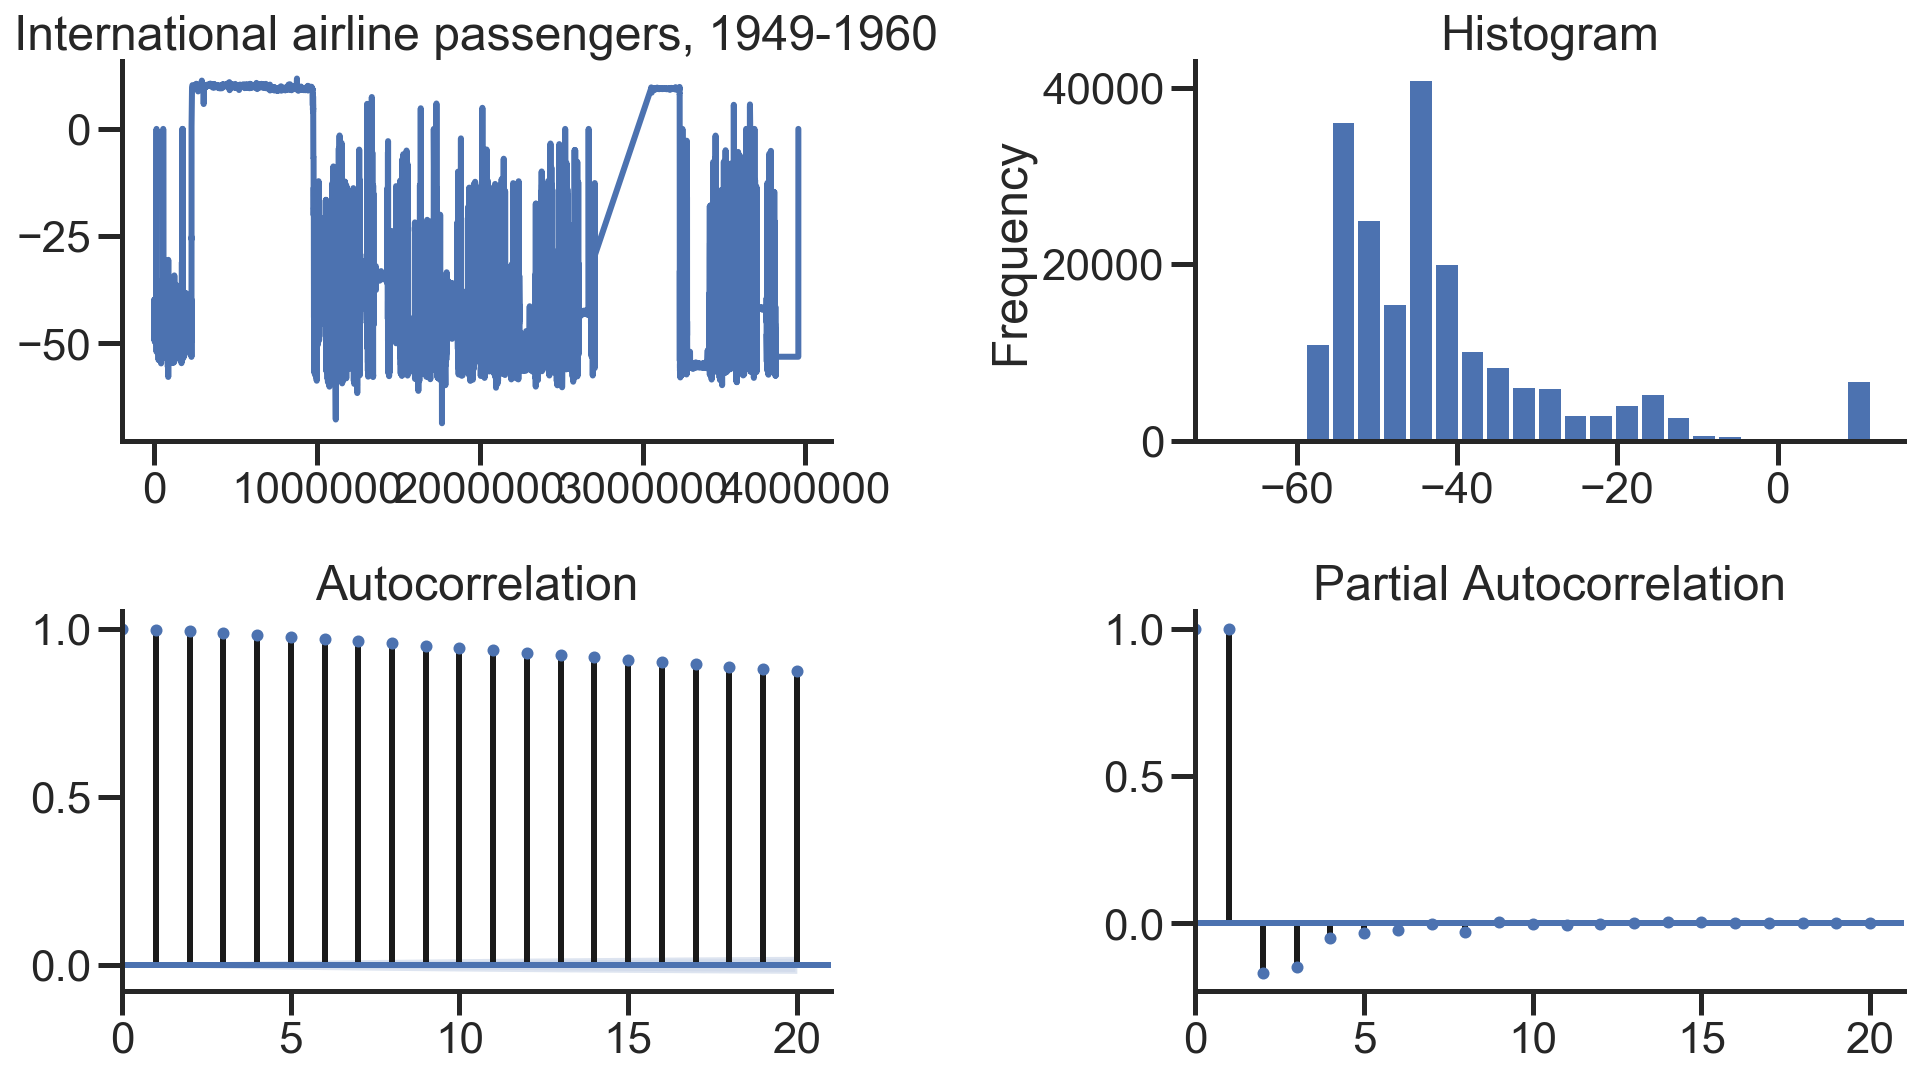

In [12]:
tsplot(air['x'], title='International airline passengers, 1949-1960', lags=20);

### Observations of these graphs:

* The airline passengers displays no trend (over time)
* There appears to be *seasonality*
* The autocorrelations just gradually decline

In [17]:
#### Data preprocessing

### Remove the timestamp and index

### Convert the data into arrays and remve the first column and the last column from the array which add no informations

# air = air.values
# air= air[:,1:]
# air = air[:,:-1:]
# air[0]



array([-47.9602, -59.9457, 6.2446800000000025], dtype=object)

In [21]:
x_scaler = MinMaxScaler()

air = x_scaler.fit_transform(air)

# # Take log of the series
# air['x'] = np.log(air['x'])
# print(air['x'].head(),"\n")
# print(air['x'].shape,"\n")


# print(air_ln_diff.head(),"\n")
# print(air_ln_diff.shape,"\n")

C:\Users\saran\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


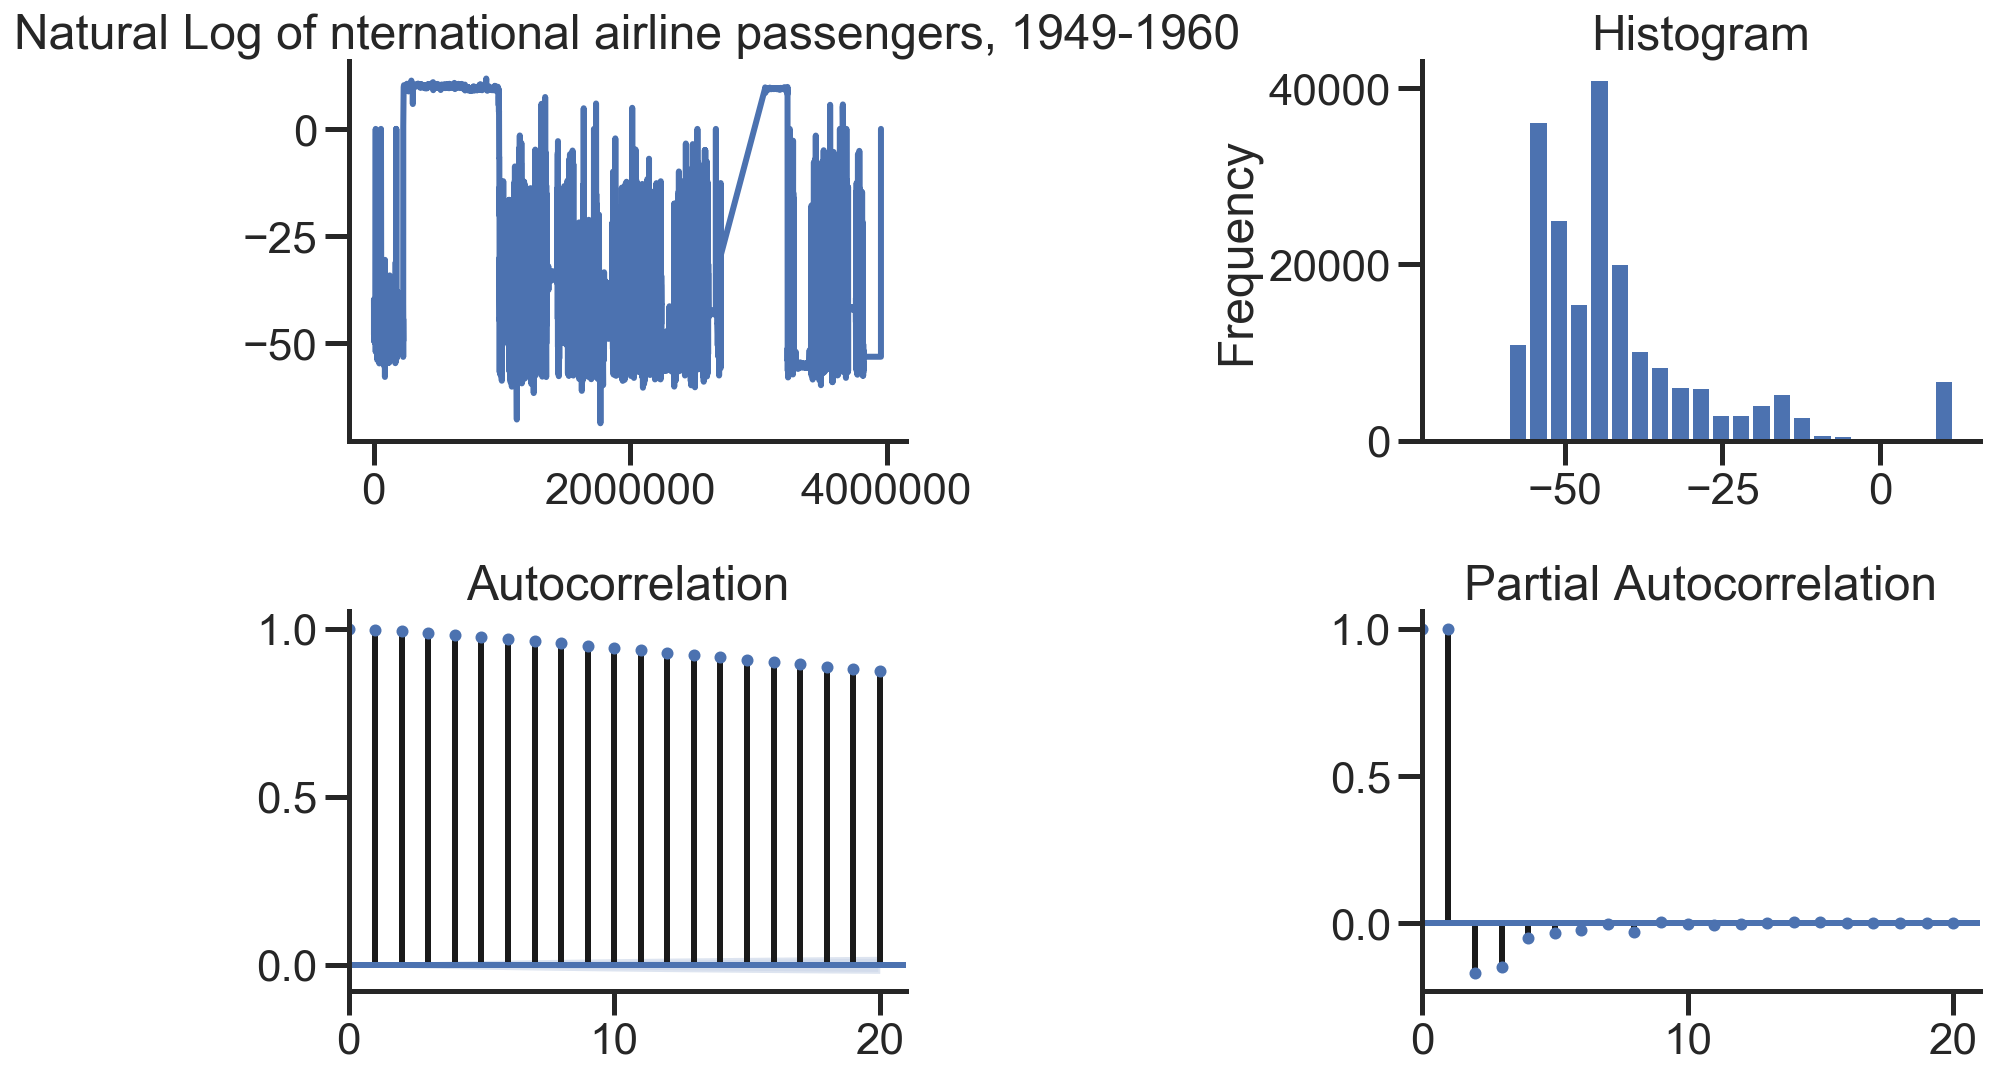

In [24]:
tsplot(air['x'], title='Natural Log of nternational airline passengers, 1949-1960', lags=20);

### 4.1 Formulation of the Seasonal ARIMA Model

The *pure* seasonal autoregressive and moving average model, $ARMA(P,Q)$, take the from

$$\Phi_P(B^s)z_t=\Theta_Q(B^s)\epsilon_t$$ 

where 

$$\Phi_P(B^2)=1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$$

and 

$$\Theta_Q(B^2)=1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots - \Theta_Q B^{Qs}$$

are the **seasonal autoregressive operator** and the **seasonal moving average operator** of orders $P$ and $Q$ with **seasonal period s**.

**Example:**

A first-order seasonal autoregressive moving average series over months (or $SARIMA(1,0,1,12)$) can be expressed as

$$ z_t = \Phi z_{t-12} + \epsilon_t + \Theta \epsilon_{t-12} $$

or

$$ (1 - \Phi B^{12})z_t = (1 + \Theta B^{12})\epsilon_t $$

In other words, this model capture the relationship between $z_t$ and its lags at the multiple of the yearly seasonal period $s=12$ months.  

The stationarity condition requires that $|\Phi|<1$ and the invertible condition requires that $|\Theta|<1$.

Similar to that for the ARIMA models, the table below summarize the behavior of the theoretical ACF and PACF of the pure seasonal ARMA models:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(P)**     |    tails off         | cutoff after lag $P$ |
| **MA(Q)**     | cutoff after lag $Q$ |    tails off         |
| **ARMA(P,Q)** |    tails off         |    tails off         |

* **Note that we use (p,d,q) to denote the orders for the non-seasonal components of the ARIMA models and (P,D,Q,s) to denote the orders for the seasonal components of the ARIMA model.**

The general formulation of the **Multiplicative Seasonal Autoregressive Integrated Moving Average (SARIMA)** model takes the following form:

$$ \phi_p(B) \Phi_P(B^s) \bigtriangledown^d \bigtriangledown^D_s z_t = \theta_q(B) \Theta_Q(B^s) \epsilon_t $$ 

where 

$\epsilon_t$ is a white noise process

$\phi_p(B)$ and $\theta_q(B)$ are non-seasonal autoregressive and moving average lag polynomials

$\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are seasonal autoregressive and moving average lag polynomials

$\bigtriangledown^d \equiv (1-B)^d$ and $\bigtriangledown^D_s \equiv (1-B^s)^D$ are the difference (or integrated) components

Therefore, the general model is denoted as $\mathbf{ARIMA(p,d,q)\times(P,D,Q)_s}$



**Example:**

Unpacking the notation, the $\mathbf{ARIMA(0,1,1)\times(P,1,1)_12}$ model becomes

$$(1-B)(1-B^{12})z_t = (1+\theta B)(1+\Theta B^{12}) \epsilon_t$$

When multiplying the lag polynomials on both side, we get

$$ (1 - B - B^{12} + B^{13}) z_t = (1 + \theta B + \Theta B^{12} + \theta \Theta B^{13}) \epsilon_t $$

Simplify gives

$$ z_t = z_{t-1} + (z_{t-12} - z_{t-13}) + \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta \Theta \epsilon_{t-13}$$


### 4.2 Building a Seasonal ARIMA Model for Forecasting

In [25]:
# Air Passengers Series
mod = sm.tsa.statespace.SARIMAX(air['x'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())

C:\Users\saran\AppData\Local\conda\conda\envs\py35\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           D.DS12.x   No. Observations:               207676
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood             -359247.944
Date:                            Sun, 25 Nov 2018   AIC                         718503.888
Time:                                    15:20:05   BIC                         718544.863
Sample:                                         0   HQIC                        718515.928
                                         - 207676                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1593      0.000    539.790      0.000       0.159       0.160
ar.L2          0.1531      0.000   

* Notice an additional argument *simple_differencing=True*. 

* This controls how the order of integration is handled in ARIMA models. 

* If *simple_differencing=True*, then the time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series. This implies that a number of initial periods are lost to the differencing process, however it may be necessary either to compare results to other packages (e.g. Stata's arima always uses simple differencing) or if the seasonal periodicity is large

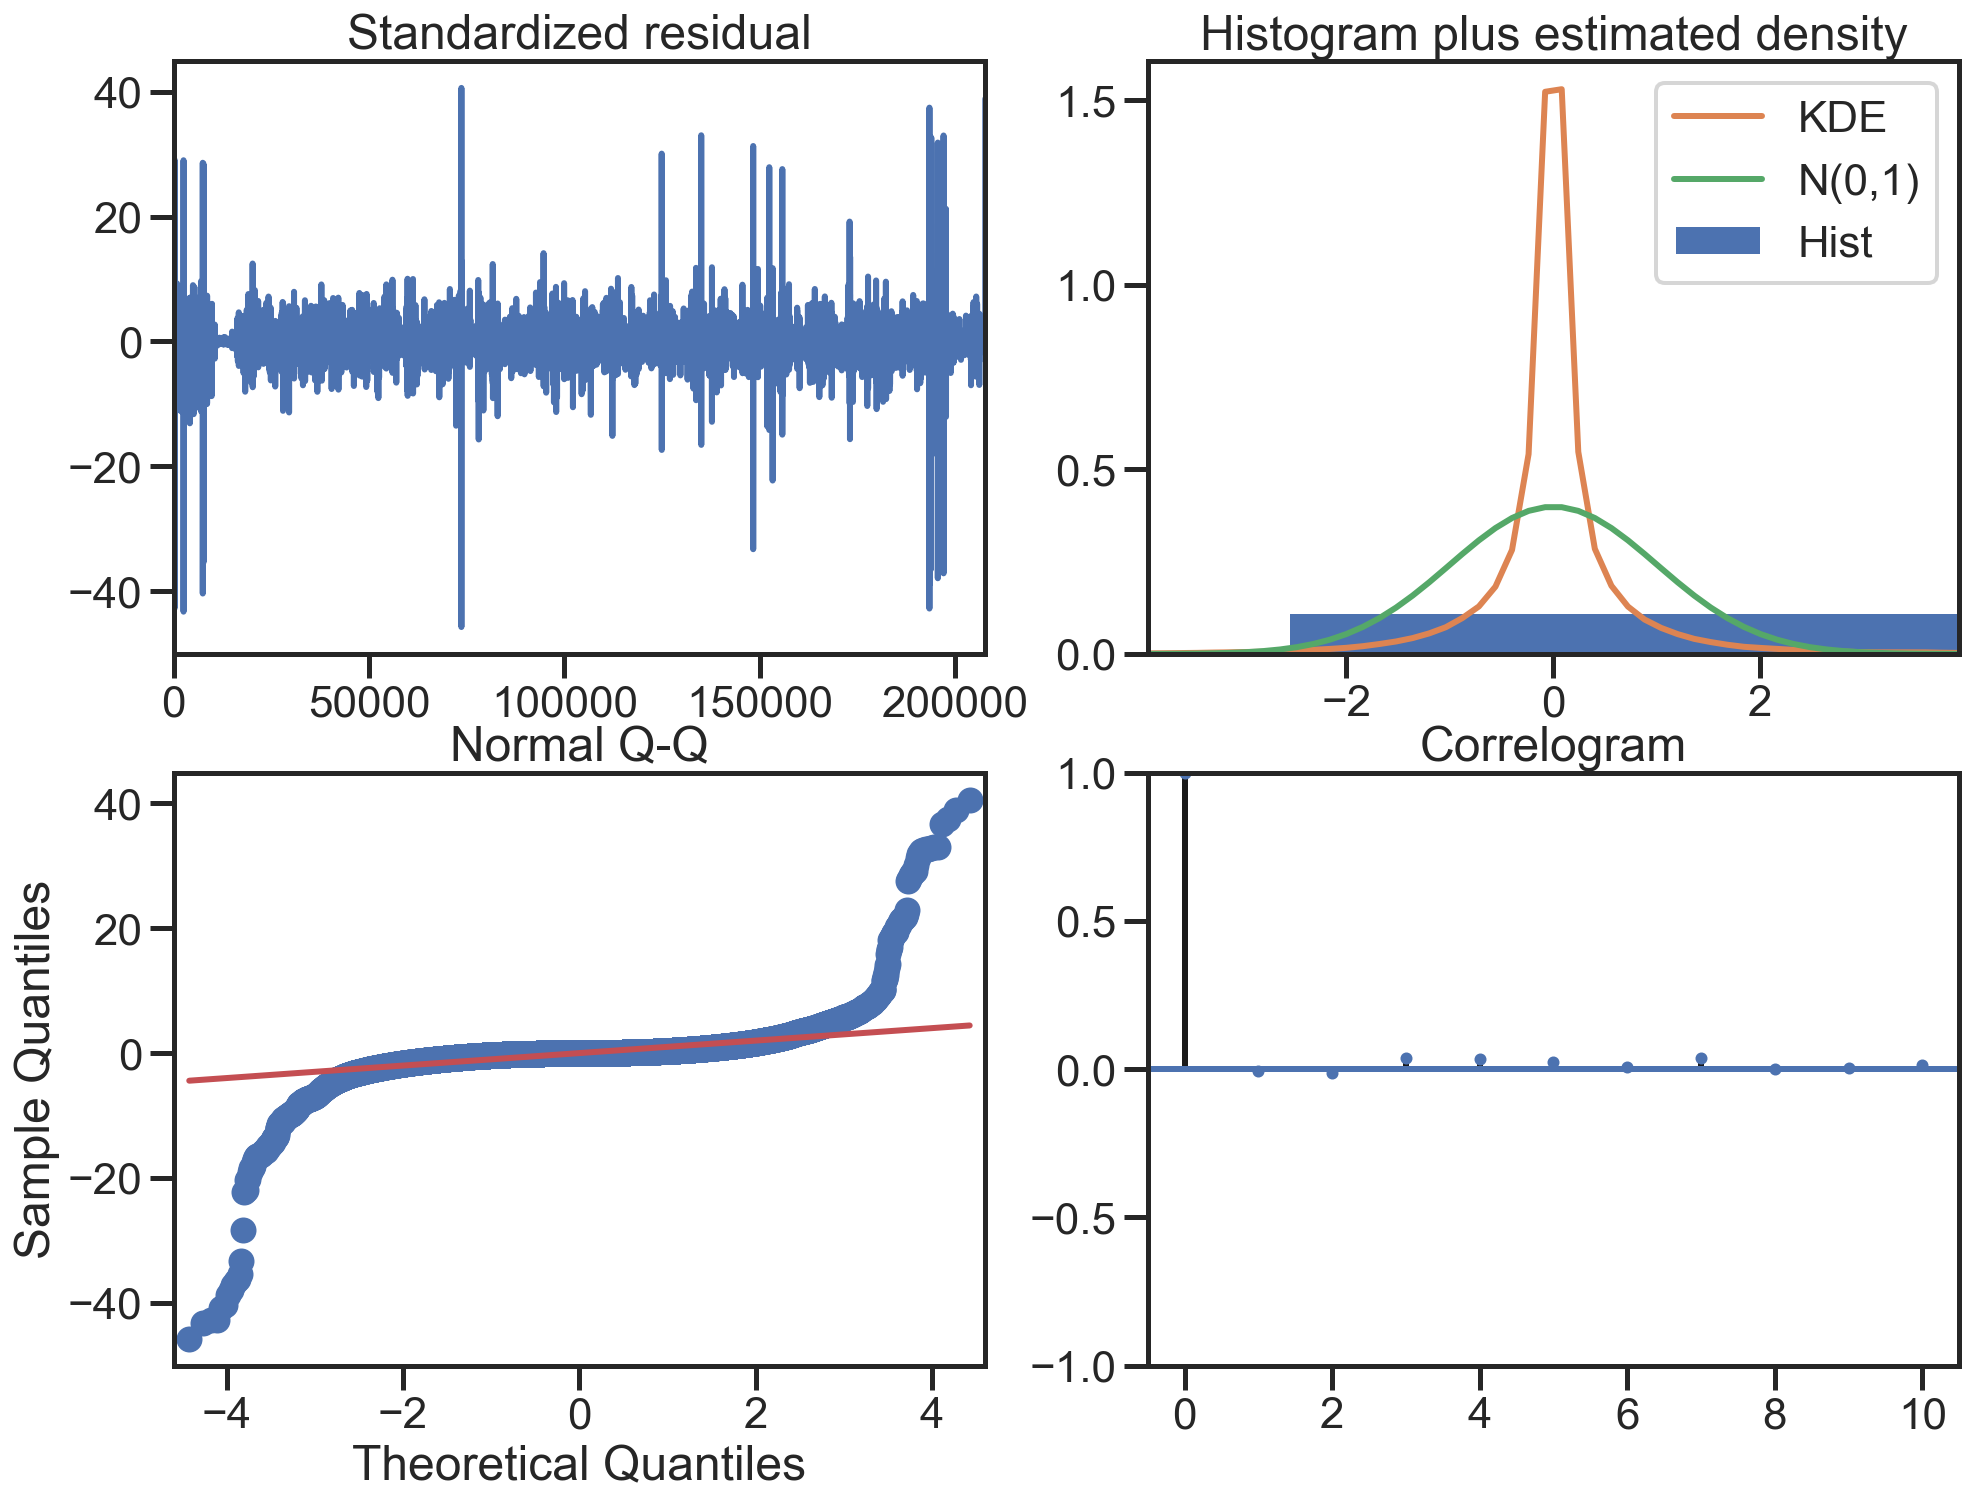

In [26]:
# Model Diagnostic

sarima_fit1.plot_diagnostics(figsize=(16, 12));

### Exercise 4: 

In [ ]:
# Step 1: Import the data series
liquor = pd.read_csv('data/liquor.csv', header=0, index_col=0, parse_dates=[0])

# Step 1b: Create the training and testing series before analyzing the series
n_sample = liquor.shape[0]
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

liquor_train = liquor.iloc[:n_train]['Value']
liquor_test  = liquor.iloc[n_train:]['Value']
print(liquor_train.shape)
print(liquor_test.shape)
print("Training Series:", "\n", liquor_train.tail(), "\n")
print("Testing Series:", "\n", liquor_test.head())

In [ ]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", liquor_train.shape, "\n")
print("First 5 observations of the training data series:", "\n", liquor_train.head(), "\n")
print("Last 5 observations of the training data series:", "\n", liquor_train.tail())

In [ ]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
#tsplot(liquor_train, title='Liquor Sales (in millions of dollars), 2007-2016', lags=??);
tsplot(liquor_train, title='Liquor Sales (in millions of dollars)', lags=40);

In [ ]:
# Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# and repeat Step 2b


In [ ]:
# Step 3: Estimate an Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)(P,D,Q)_s

#mod = sm.tsa.statespace.SARIMAX(liquor, order=(?,?,?), seasonal_order=(?,?,?,?))

mod = sm.tsa.statespace.SARIMAX(liquor_train, order=(0,1,1), seasonal_order=(0,1,0,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

In [ ]:
# Step 4: Conduct model diagnostic check
sarima_fit2.plot_diagnostics();

# Discuss these plots

In [ ]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(liquor_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(liquor_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = liquor_train.index[sarima_fit2.loglikelihood_burn]
pred_end = liquor_test.index[-1]
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Liquor Sales (in millions of dollars)")
ax1.legend(loc='best');
fig.tight_layout();
## Discuss the results.  How does your forecast look?